In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# EDA

In [3]:
df = pd.read_csv('diamonds.csv')

# 53940 rows * 11 columns
# index counter
# carat: weight of the diamond (0.2,5.01)
# cut: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
# color: diamond color (J,D) J is worst, D is best
# clarity: how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best)) 
#          IF = Internally Flawless, I1 = Included (inclusions that are CLEARLY visible w/ 10x zoom), SI = Slightly Included, VS = Very Slightly Included
# depth: depth percentage = z/mean(x,y), (43,79), (I assume this is based on exact numbers, not the estimated numbers from the data)
# table: width of diamond's table as a percentage of average diameter (43,95), 
# price: USD ($326,$18,823)
# x: length in mm (0,10.74)
# y: width in mm (0,58.9)
# z: depth in mm (0,31.8)


In [4]:
# Fortunately, the categorical variables, cut, color, and clarity are ordinal, so I can map these values using label encoding. 
# This'll help for finding correlation between these variables and the price.
dfcopy = df.copy()
cutmap = {'Fair':0, 'Good':1, 'Very Good':2, 'Premium':3, 'Ideal':4}
colormap = {'J':0, 'I':1, 'H':2, 'G':3, 'F':4, 'E':5, 'D':6}
claritymap = {'I1':0, 'SI2':1, 'SI1':2, 'VS2':3, 'VS1':4, 'VVS2':5, 'VVS1':6, 'IF':7}

dfcopy['cut'] = dfcopy['cut'].map(cutmap)
dfcopy['color'] = dfcopy['color'].map(colormap)
dfcopy['clarity'] = dfcopy['clarity'].map(claritymap)
#dfcopy.head() # Now all of the columns are numerical.

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75


In [5]:
corr = dfcopy.corr()
corr.style.background_gradient(cmap='coolwarm')

# X, Y, and Z, and carat have really high correlation with price and with each other. 
# I'll consider putting those 4 features in my model.

# I encoded the categorical variables based on the context of the dataset rather than the actual data.
# Even if I encoded the categorical variables based on the actual data, the correlation with price never exceeds |.175| 
# The other columns, cut, color, clarity, depth, and table have low correlation with price.
# I want to explore these columns with more visualizations to understand why they have low correlation. 

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
Unnamed: 0,1.000000,-0.377983,0.096492,0.095098,0.208598,-0.034800,-0.100830,-0.306873,-0.405440,-0.395843,-0.399208
carat,-0.377983,1.000000,-0.134967,-0.291437,-0.352841,0.028224,0.181618,0.921591,0.975094,0.951722,0.953387
cut,0.096492,-0.134967,1.000000,0.020519,0.189175,-0.218055,-0.433405,-0.053491,-0.125565,-0.121462,-0.149323
color,0.095098,-0.291437,0.020519,1.000000,-0.025631,-0.047279,-0.026465,-0.172511,-0.270287,-0.263584,-0.268227
clarity,0.208598,-0.352841,0.189175,-0.025631,1.000000,-0.067384,-0.160327,-0.146800,-0.371999,-0.358420,-0.366952
depth,-0.034800,0.028224,-0.218055,-0.047279,-0.067384,1.000000,-0.295779,-0.010647,-0.025289,-0.029341,0.094924
table,-0.100830,0.181618,-0.433405,-0.026465,-0.160327,-0.295779,1.000000,0.127134,0.195344,0.183760,0.150929
price,-0.306873,0.921591,-0.053491,-0.172511,-0.146800,-0.010647,0.127134,1.000000,0.884435,0.865421,0.861249
x,-0.405440,0.975094,-0.125565,-0.270287,-0.371999,-0.025289,0.195344,0.884435,1.000000,0.974701,0.970772
y,-0.395843,0.951722,-0.121462,-0.263584,-0.358420,-0.029341,0.183760,0.865421,0.974701,1.000000,0.952006


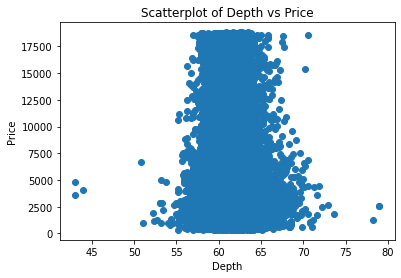

In [8]:
plt.scatter(df['depth'], df['price'])
plt.xlabel('Depth')
plt.ylabel('Price')
plt.title('Scatterplot of Depth vs Price')
plt.show()
# The low corrrelation is clear, diamonds with the same depth have prices that range from near $0 to $17000+

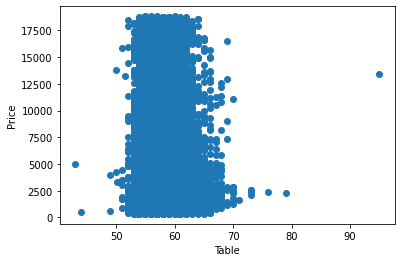

In [7]:
plt.scatter(df['table'], df['price'])
plt.xlabel('Table')
plt.ylabel('Price')
plt.show()
# Similar to the above visualization, diamonds with the same table can vary widely in price, low correlation is clear.

In [141]:
testdf = dfcopy.copy()
testdf['x_estimate'] = testdf.apply(lambda row: round(row.x),axis=1)
testdf

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z,x_estimate
0,1,0.23,4,5,1,61.5,55.0,326,3.95,3.98,2.43,4
1,2,0.21,3,5,2,59.8,61.0,326,3.89,3.84,2.31,4
2,3,0.23,1,5,4,56.9,65.0,327,4.05,4.07,2.31,4
3,4,0.29,3,1,3,62.4,58.0,334,4.20,4.23,2.63,4
4,5,0.31,1,0,1,63.3,58.0,335,4.34,4.35,2.75,4
...,...,...,...,...,...,...,...,...,...,...,...,...
53935,53936,0.72,4,6,2,60.8,57.0,2757,5.75,5.76,3.50,6
53936,53937,0.72,1,6,2,63.1,55.0,2757,5.69,5.75,3.61,6
53937,53938,0.70,2,6,2,62.8,60.0,2757,5.66,5.68,3.56,6
53938,53939,0.86,3,2,1,61.0,58.0,2757,6.15,6.12,3.74,6


In [13]:
# The categorical variables, cut, color, and clarity have discrete values so a scatterplot won't be effective.
# However, I can look at the spread of price for each possible value of the categorical variables.
# The smaller the spread, the better the variable is at predicting price. I'll be using IQR as my measurement of spread.

# I'll also show the spread of the middle 50% of carat, x, y, and z. It's not ideal to compare categorical and numerical variables,
# but it'll give context to what a 'high' or 'low' spread could look like. 
# 40% of the diamonds have 'Ideal' cuts, besides that no value of the categorical variables exceed 25% of the diamonds.
# If one value of a categorical variable has a higher spread than the middle 50% of the highly correlated numerical variables,
# that clearly shows that the categorical variables are not a good predictor of price.

def getiqr(cond): # function used to save space, simply gets the IQR of price based on a condition in the dataframe
    return df.price[cond].quantile(.75) - df.price[cond].quantile(.25)

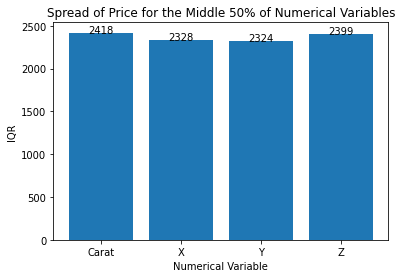

In [20]:
# df >= 25%ile and df <= 75%ile
Y = [getiqr((df.carat >= 0.4) & (df.carat <= 1.04)), getiqr((df.x >= 4.71) & (df.x <= 6.54)),
    getiqr((df.y >= 4.72) & (df.y <= 6.54)), getiqr((df.z >= 2.91) & (df.z <= 4.04)),]
X = ['Carat','X','Y','Z']
plt.bar(X,Y)
for index, value in enumerate(Y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.ylabel('IQR')
plt.xlabel('Numerical Variable')
plt.title('Spread of Price for the Middle 50% of Numerical Variables')
plt.show()

# None of these values are above $2418. Let's see how the categorical variables compare.

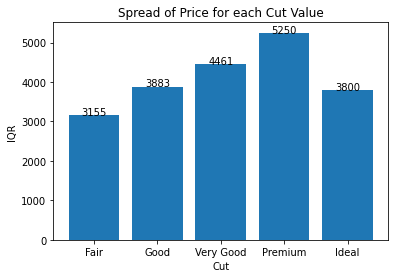

In [22]:
Y = [getiqr(df.cut == 'Fair'), getiqr(df.cut == 'Good'), getiqr(df.cut == 'Very Good'), getiqr(df.cut == 'Premium'), getiqr(df.cut == 'Ideal')]
X = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']
plt.bar(X,Y)
for index, value in enumerate(Y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.ylabel('IQR')
plt.xlabel('Cut')
plt.title('Spread of Price for each Cut Value')
plt.show()
# 3% of the diamonds have 'Fair' cuts. All of these IQRs are significantly above $2418. 

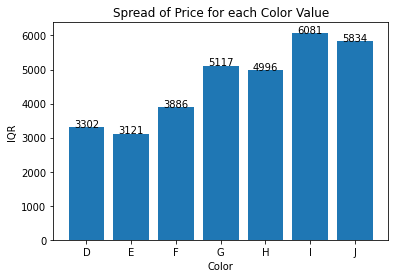

In [24]:
Y = [getiqr(df.color == 'D'), getiqr(df.color == 'E'), getiqr(df.color == 'F'), getiqr(df.color == 'G'), 
    getiqr(df.color == 'H'), getiqr(df.color == 'I'), getiqr(df.color == 'J')]
X = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
plt.bar(X,Y)
for index, value in enumerate(Y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.ylabel('IQR')
plt.xlabel('Color')
plt.title('Spread of Price for each Color Value')
plt.show()
# Again, all of these IQRs are significantly above $2418. 10% of the diamonds have 'I' color, 5% 'J' color 

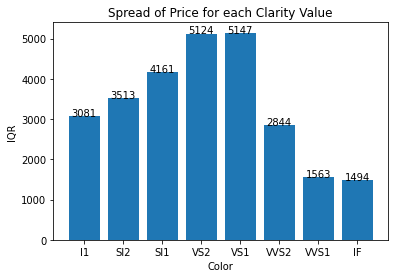

In [26]:
Y = [getiqr(df.clarity == 'I1'), getiqr(df.clarity == 'SI2'), getiqr(df.clarity == 'SI1'), getiqr(df.clarity == 'VS2'),
    getiqr(df.clarity == 'VS1'), getiqr(df.clarity == 'VVS2'), getiqr(df.clarity == 'VVS1'), getiqr(df.clarity == 'IF')]
X = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']
plt.bar(X,Y)
for index, value in enumerate(Y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.ylabel('IQR')
plt.xlabel('Color')
plt.title('Spread of Price for each Clarity Value')
plt.show()

# VVS1 (6.8% of diamonds) and IF (3.3%) are the only clarities less than a $2418 IQR. 

Text(0.5, 1.0, 'Scatterplot of X vs Price')

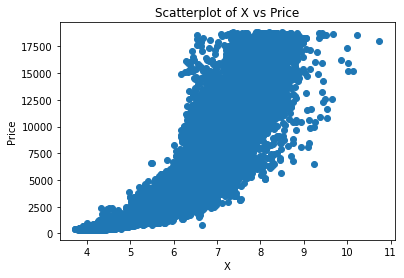

In [34]:
# The above bar charts show that the categorical variables are not a good predictor of price, and will not be used in my model.
# Back to the highly correlated numerical variables: carat, x, y and z.
# I want to check for outliers or incorrect data so I can remove them

# 20 rows have a 0 for either the x, y or z value. This is clearly incorrect data so I'll remove those rows.
df = df[(df.z!=0) & (df.y!=0) & (df.x!=0)]

# I'll be showing scatterplots of these variables vs price to check for outliers and show the relationship.
plt.scatter(df.x, df.price)
plt.xlabel('X')
plt.ylabel('Price')
plt.title('Scatterplot of X vs Price')
# No crazy outliers here.

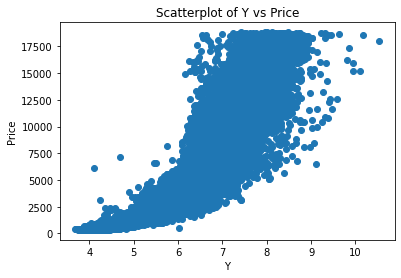

In [78]:
plt.scatter(df.y, df.price)
plt.xlabel('Y')
plt.ylabel('Price')
plt.title('Scatterplot of Y vs Price')
df[df.y>30].head()
# These 2 Y values are clearly huge outliers. Also the depth does not match up. The Y value is clearly incorrect and will be removed.
df = df[df.y<=30]

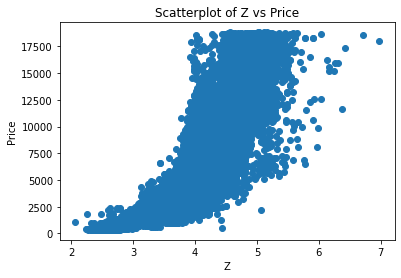

In [76]:
plt.scatter(df.z, df.price)
plt.xlabel('Z')
plt.ylabel('Price')
plt.title('Scatterplot of Z vs Price')
df[(df.z>30) | (df.z<2)].head()
# These 4 Z values are outliers and they don't match up with the depth. These will be removed.
df = df[(df.z<=30) & (df.z>=2)]


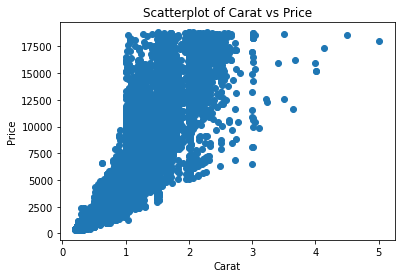

In [83]:
plt.scatter(df.carat, df.price)
plt.xlabel('Carat')
plt.ylabel('Price')
plt.title('Scatterplot of Carat vs Price')
# There are 32 rows where the carat is above 3. This is relatively huge but the depth values for all of these rows are correct.
# And they follow the general trend so I will not remove any rows due to carat.

Unnamed: 0   -0.307073
carat         0.921581
depth        -0.010628
table         0.127305
price         1.000000
x             0.887213
y             0.888810
z             0.882575
volume        0.923640
Name: price, dtype: float64


Text(0.5, 1.0, 'Scatterplot of Volume vs Price')

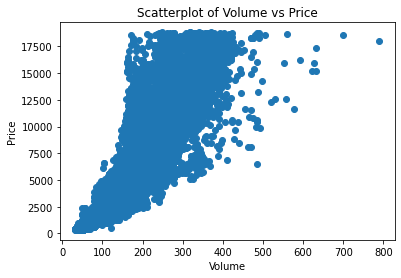

In [92]:
# Since x, y, and z are all highly correlated with each other, and they all refer to the size of the diamond,
# I'll be creating a new feature called 'volume' which will be x*y*z
df['volume'] = df.x*df.y*df.z
corrs = df.corr()
print(corrs.price) # Y and Z has a slightly higher correlation after removing outliers. Volume is higher than all other features.
# I'll be using volume and carat as my features.

plt.scatter(df.volume, df.price)
plt.xlabel('Volume')
plt.ylabel('Price')
plt.title('Scatterplot of Volume vs Price')
# Nothing too out of the ordinary here.

# Model Evaluation

In [107]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score, KFold, cross_validate, ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings("ignore") # Since I use .append instead on .concat with pandas, I get many warnings. They take up a lot of space

In [94]:
volcat = df[['carat','volume','price']]
X = volcat.drop('price', axis=1)
y = volcat.price
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.25, shuffle=True)
# Carat and Volume are my only features for my models. I shuffle the data to get meaningful cv results.

In [108]:
# This code block might take a while to run.
# I found 10 models from https://scikit-learn.org/stable/modules/classes.html to try out.
# These models are regressors, need no custom parameters, unique from each other, and they all run.

models = [(LinearRegression(),'Linear'),(DecisionTreeRegressor(), 'Decision Tree'), (HuberRegressor(),'Huber'), 
            (KNeighborsRegressor(), 'K-Nearest Neighbors'), (PassiveAggressiveRegressor(), 'Passive Aggressive'),
            (RandomForestRegressor(), 'Random Forest'), (GradientBoostingRegressor(), 'Gradient Boosting'),
            (AdaBoostRegressor(), 'AdaBoost'), (BaggingRegressor(), 'Bagging'), (ExtraTreesRegressor(),'Extra Trees')]
             # I'm using tuples with string so it's easier to label my dataframe
results_df = pd.DataFrame({'Model': [], 'MAE': [],'RMSE': [], 'r2': []})

# I don't shuffle cv here because I want each model to be trained on the same splits. I think it's easier to compare results that way.
# Linear, Huber, and KNeighbors' metrics don't vary with the same splits, while most of the other models vary a little (<.01 r2).
# Passive Aggressive's metrics can vary a lot. If I want to reroll, I run the previous code block again.
for i in range(len(models)): 
    cvscores = cross_validate(models[i][0], X_train, y_train, cv=10, scoring=['neg_root_mean_squared_error','r2','neg_mean_absolute_error'])
    results_df = results_df.append({'Model': models[i][1], "MAE": np.mean(-cvscores['test_neg_mean_absolute_error']), 
    'RMSE': np.mean(-cvscores['test_neg_root_mean_squared_error']), 'r2':np.mean(cvscores['test_r2'])}, ignore_index=True)
#results_df

,Model,MAE,RMSE,r2
0,Linear,1003.663443,1532.624275,0.852584
1,Decision Tree,914.386649,1760.653864,0.805448
2,Huber,952.427461,1599.144888,0.839521
3,K-Nearest Neighbors,857.623681,1508.135604,0.857271
4,Passive Aggressive,1170.285012,1838.875653,0.776632
5,Random Forest,816.888958,1478.600441,0.862812
6,Gradient Boosting,802.025242,1402.346739,0.876575
7,AdaBoost,895.194789,1489.753115,0.860701
8,Bagging,836.029445,1515.734553,0.855818
9,Extra Trees,836.802505,1585.126346,0.842309


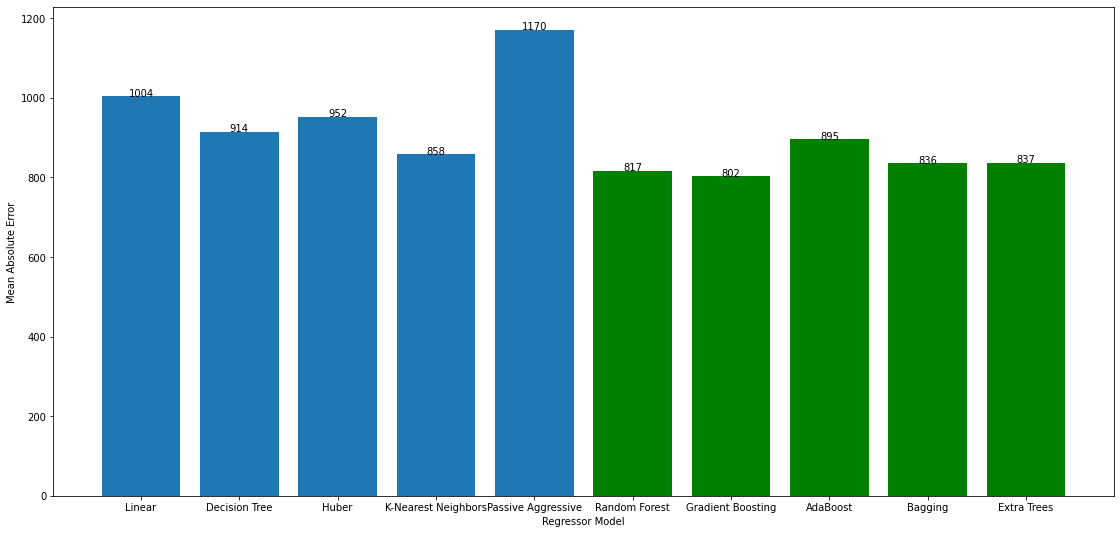

In [130]:
plt.figure(figsize=(19, 9))
x = results_df.Model
y = results_df.MAE
bars = plt.bar(x,y)
plt.xlabel('Regressor Model')
plt.ylabel('Mean Absolute Error')
[bars[x].set_facecolor('green') for x in range(5,10)]
for index, value in enumerate(y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.show()
# I put the ensemble models in a different color. They seem to perform better than the non-ensemble models.
# AdaBoost has the highest MAE out of the ensemble models.

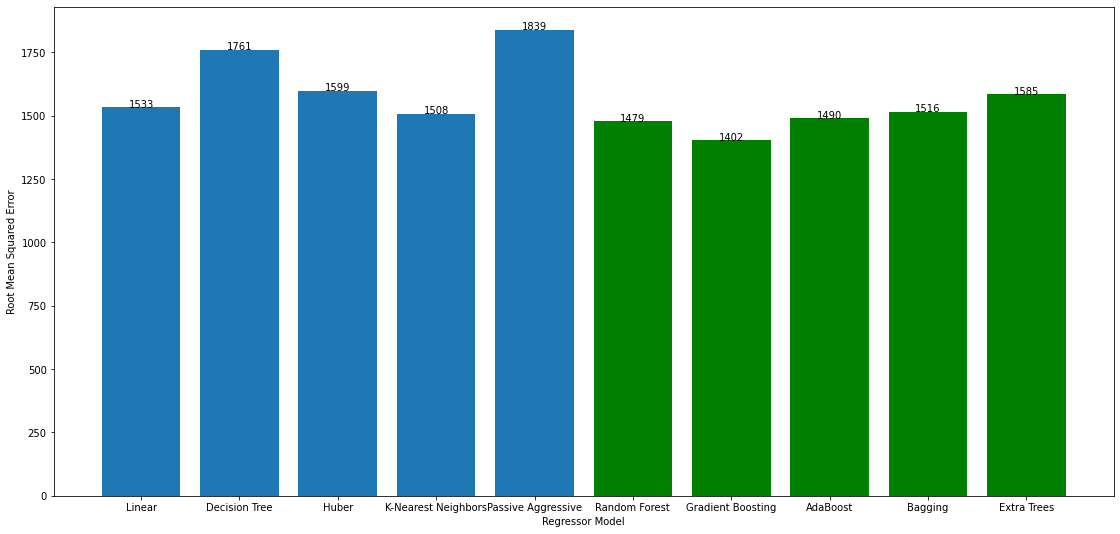

In [131]:
plt.figure(figsize=(19, 9))
x = results_df.Model
y = results_df.RMSE
bars = plt.bar(x,y)
plt.xlabel('Regressor Model')
plt.ylabel('Root Mean Squared Error')
[bars[x].set_facecolor('green') for x in range(5,10)]
for index, value in enumerate(y):
    plt.text(index, value,
             str(round(value)),ha='center')
plt.show()
# Decision Tree stands out for having a high RMSE, compared to its MAE. 
# Extra Trees has the highest RMSE out of the ensemble models.

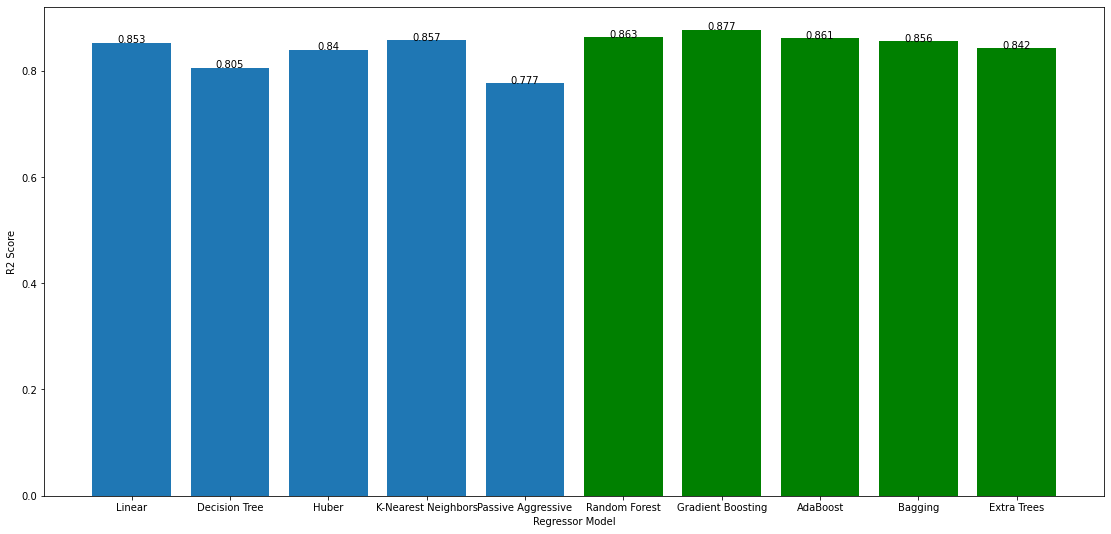

In [135]:
plt.figure(figsize=(19, 9))
x = results_df.Model
y = results_df.r2
bars = plt.bar(x,y)
plt.xlabel('Regressor Model')
plt.ylabel('R2 Score')
[bars[x].set_facecolor('green') for x in range(5,10)]
for index, value in enumerate(y):
    plt.text(index, value,
             str(round(value,3)),ha='center')
plt.show()

# After looking at these 3 visualizations, it's clear that Gradient Boosting is the best model.
# It has had the highest r2 score, lowest MAE, and lowest RMSE out of all the models. 
# The Passive Agressive model performs significantly worse than the other models, with the lowest r2, and highest MAE and RMSE.
# I think it's beucase the model is made for sequential inputs and step-by-step learning, but I'm using the entire dataset at once.